In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')

In [2]:
def grad(X, y_hat, w):
    return -2*X.T @ (y_hat - X @ w)

def hessian(X):
    return 2 * X.T @ X

def gd(X, y_hat, w, gamma, T=100):
    weights = [w]
    for i in range (T):
        w = w - gamma * grad(X, y_hat, w)
        weights.append(w)
        if np.linalg.norm(w - weights[-2]) < 10e-7: return np.array(weights), i
    return np.array(weights), T

def sgd(X, y_hat, w, gamma, T=100):
    weights = [w]
    j = random.randint(0, len(X)-1)
    for i in range (T):
        w = w - gamma * grad(np.array([X[j,:]]), np.array([y_hat[j]]), w)
        weights.append(w)
        if np.linalg.norm(w - weights[-2]) < 10e-7: return np.array(weights), i
    return np.array(weights), T

def newton(X, y_hat, w, T=100):
    weights = [w]
    for i in range(T):
        w = w - np.linalg.inv(hessian(X)) @ grad(X, y_hat, w)
        weights.append(w)
        if np.linalg.norm(w - weights[-2]) < 10e-7: return np.array(weights), i
    return np.array(weights), T

def BFGS(X, y_hat, w, T=100):
    weights = [w]
    B = np.eye(len(w)) / 1000
    for i in range(T):
        w = w - B @ grad(X, y_hat, w)
        w_prev = weights[-1]
        delta = np.array(w - w_prev)
        gamma = np.array(grad(X, y_hat, w) - grad(X, y_hat, w_prev))
        dot = delta @ gamma
        if dot == 0:
            print("BFGS terminating.")
            return np.array(weights) 
        
        B = B - (( np.outer(delta, gamma) @ B + B @ np.outer(gamma, delta) ) / dot) + (1 + (gamma.T @ B @ gamma) / dot) * ((np.outer(delta, delta)) / dot)
        weights.append(w)  
        if np.linalg.norm(w - w_prev) < 10e-7:
            return np.array(weights), i      
    return np.array(weights), T


def L_BFGS(X, y_hat, w, m=5, T=100):
    weights = [w]
    deltas = [0]
    gammas = [0]
    ros = [0]
    B1 = np.eye(len(w)) / 1000000
    for k in range(T):
        q = grad(X, y_hat, w)
        alphas = np.zeros(k+1)
        for i in range(k, max(k-m, 0), -1):
            alphas[i] = ros[i] * (deltas[i].T @ q)
            q = q - alphas[i] * gammas[i]

        if k == 0: r = B1 @ q ## first iteration
        else: r = ((deltas[k].T @ gammas[k]) / (gammas[k].T @ gammas[k]) * np.eye(len(w))) @ q

        for i in range(max(k-m + 1, 1), k+1):
            beta = ros[i] * (gammas[i].T @ r)
            r = r + deltas[i] * (alphas[i] - beta)

        w = w - r
        weights.append(w)

        if np.linalg.norm(w - weights[-2]) < 10e-7: return np.array(weights), k

        gammas.append(np.nan_to_num(grad(X, y_hat, w) - grad(X, y_hat, weights[-2])))
        deltas.append(w - weights[-2])
        ros.append(1 / deltas[-1] @ gammas[-1])
    
    return np.array(weights), T

def point_generator(N, bias=True):
    X = np.array(range(1,N+1))
    y_hat = X + np.random.uniform(size=N)
    if bias: X = np.insert(X.reshape(-1, 1), 0, np.ones(N), axis=1)
    else: X = X.reshape(-1, 1)
    return X, y_hat


def plot_linear_regression(X, y_hat, W, descent, num_steps, rmse, ax, fails=False):
    ax.plot(X[:,1], y_hat, '.', label='Generated points')
    if not fails: ax.plot(X[:,1], X@W[-1,:], label=f'Fitted line using with {num_steps} steps before termination')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{descent} with {round(rmse, 2)} RMSE')
    ax.legend()

def RMSE(y, y_hat):
    return np.sqrt(np.mean((y - y_hat)**2))

In [3]:
methods = ['Gradient descent', 'Stochastic gradient descent', 'Newton method', 'BFGS', 'L-BFGS']

We start with **N=50**, we observe that Newton method converges in 1 step, with BFGS and L-BFGS closing in with 4 steps. All methods achieve good RMSE.

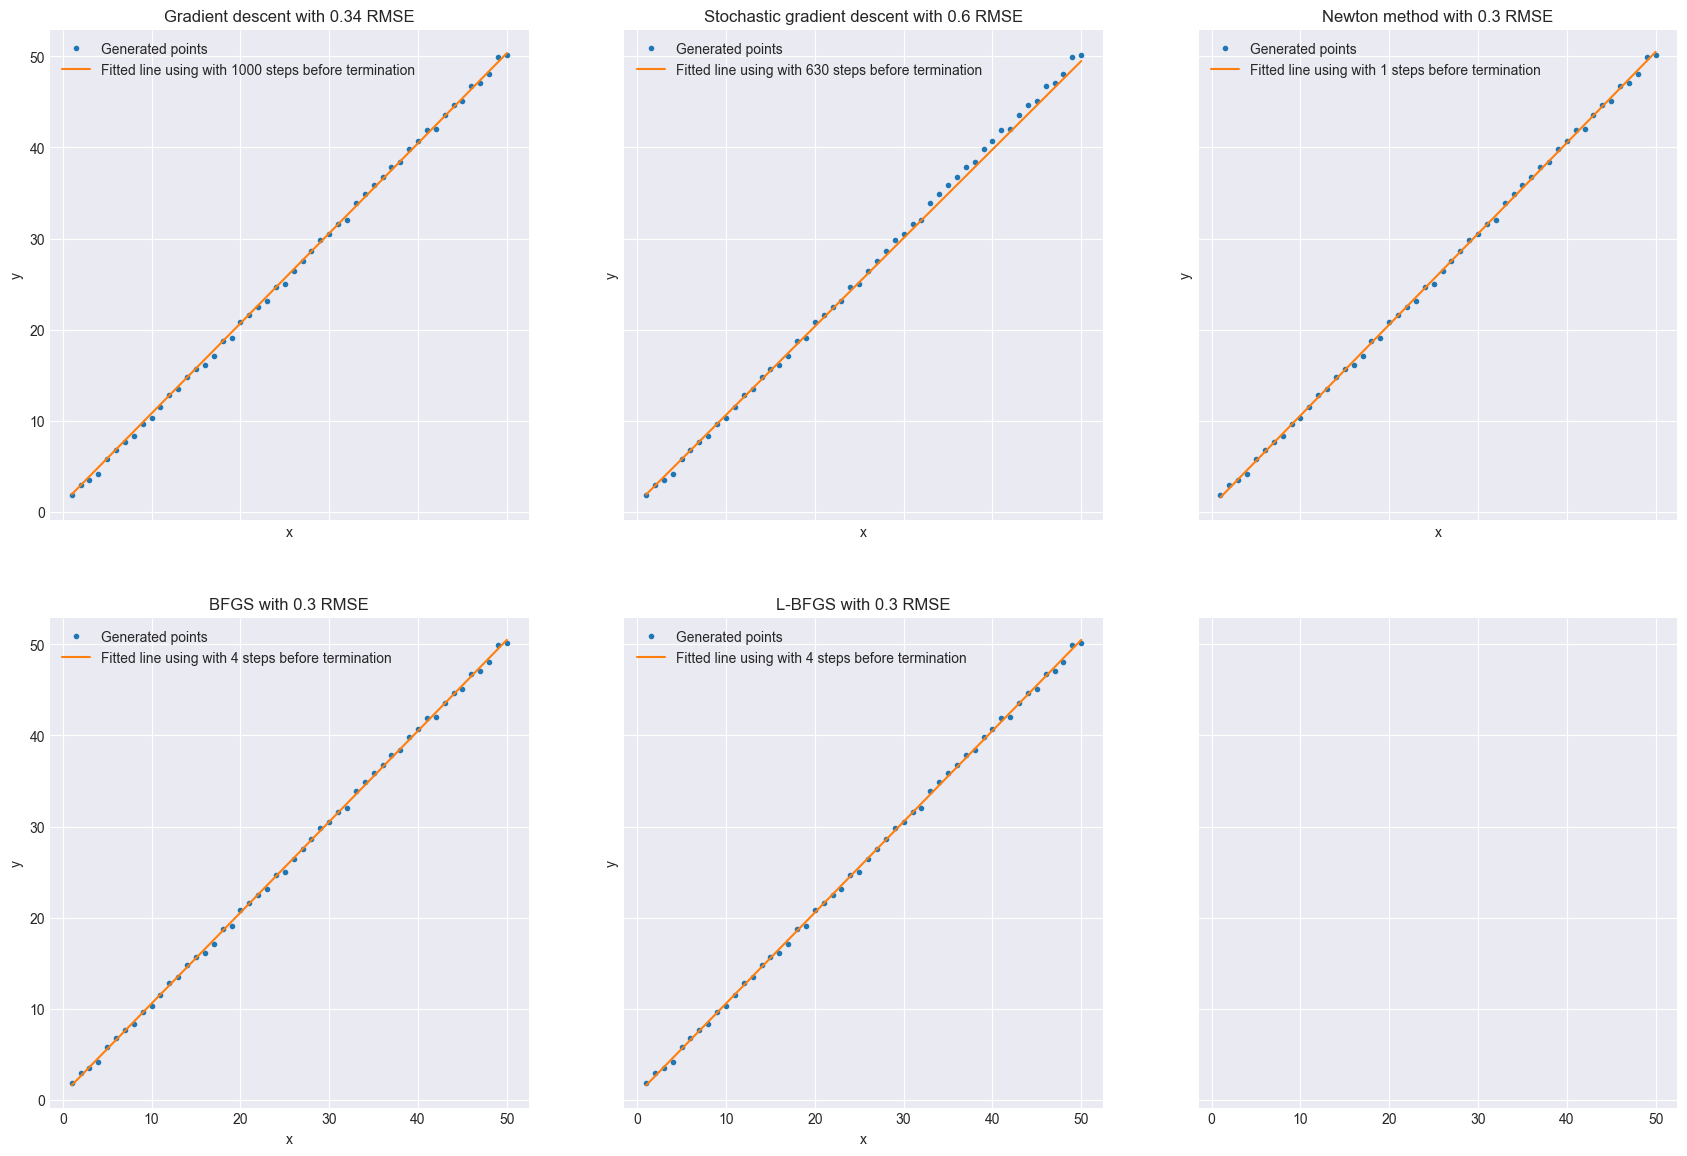

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(21,14), sharex=True, sharey=True)
N = 50
X, y_hat = point_generator(N)
max_steps = 1000
learning_rate = 10e-8
for i,descent in enumerate(methods):
    fail = False
    if descent == 'Gradient descent':
        W, time_steps = gd(X, y_hat, np.array([1,3]), learning_rate, max_steps)
    elif descent == 'Stochastic gradient descent':
        W, time_steps = sgd(X, y_hat, np.array([1,3]), learning_rate*80, max_steps)
    elif descent == 'Newton method':
        W, time_steps = newton(X, y_hat, np.array([1,3]), max_steps)
        # fail = True
    elif descent == 'BFGS':
        W, time_steps = BFGS(X, y_hat, np.array([1,3]), max_steps)
    elif descent == 'L-BFGS':
        W, time_steps = L_BFGS(X, y_hat, np.array([1,3]), 0, max_steps)
    plot_linear_regression(X, y_hat, W, descent, time_steps, RMSE(X@W[-1,:], y_hat), axs[i//3][i%3], fail)

We move to **N=100** points. We see that Newton's method still converges in 1 step, while BFGS and L-BFGS still in 4 steps. Gradient descent needs a bit of work but still achieves good RMSE.

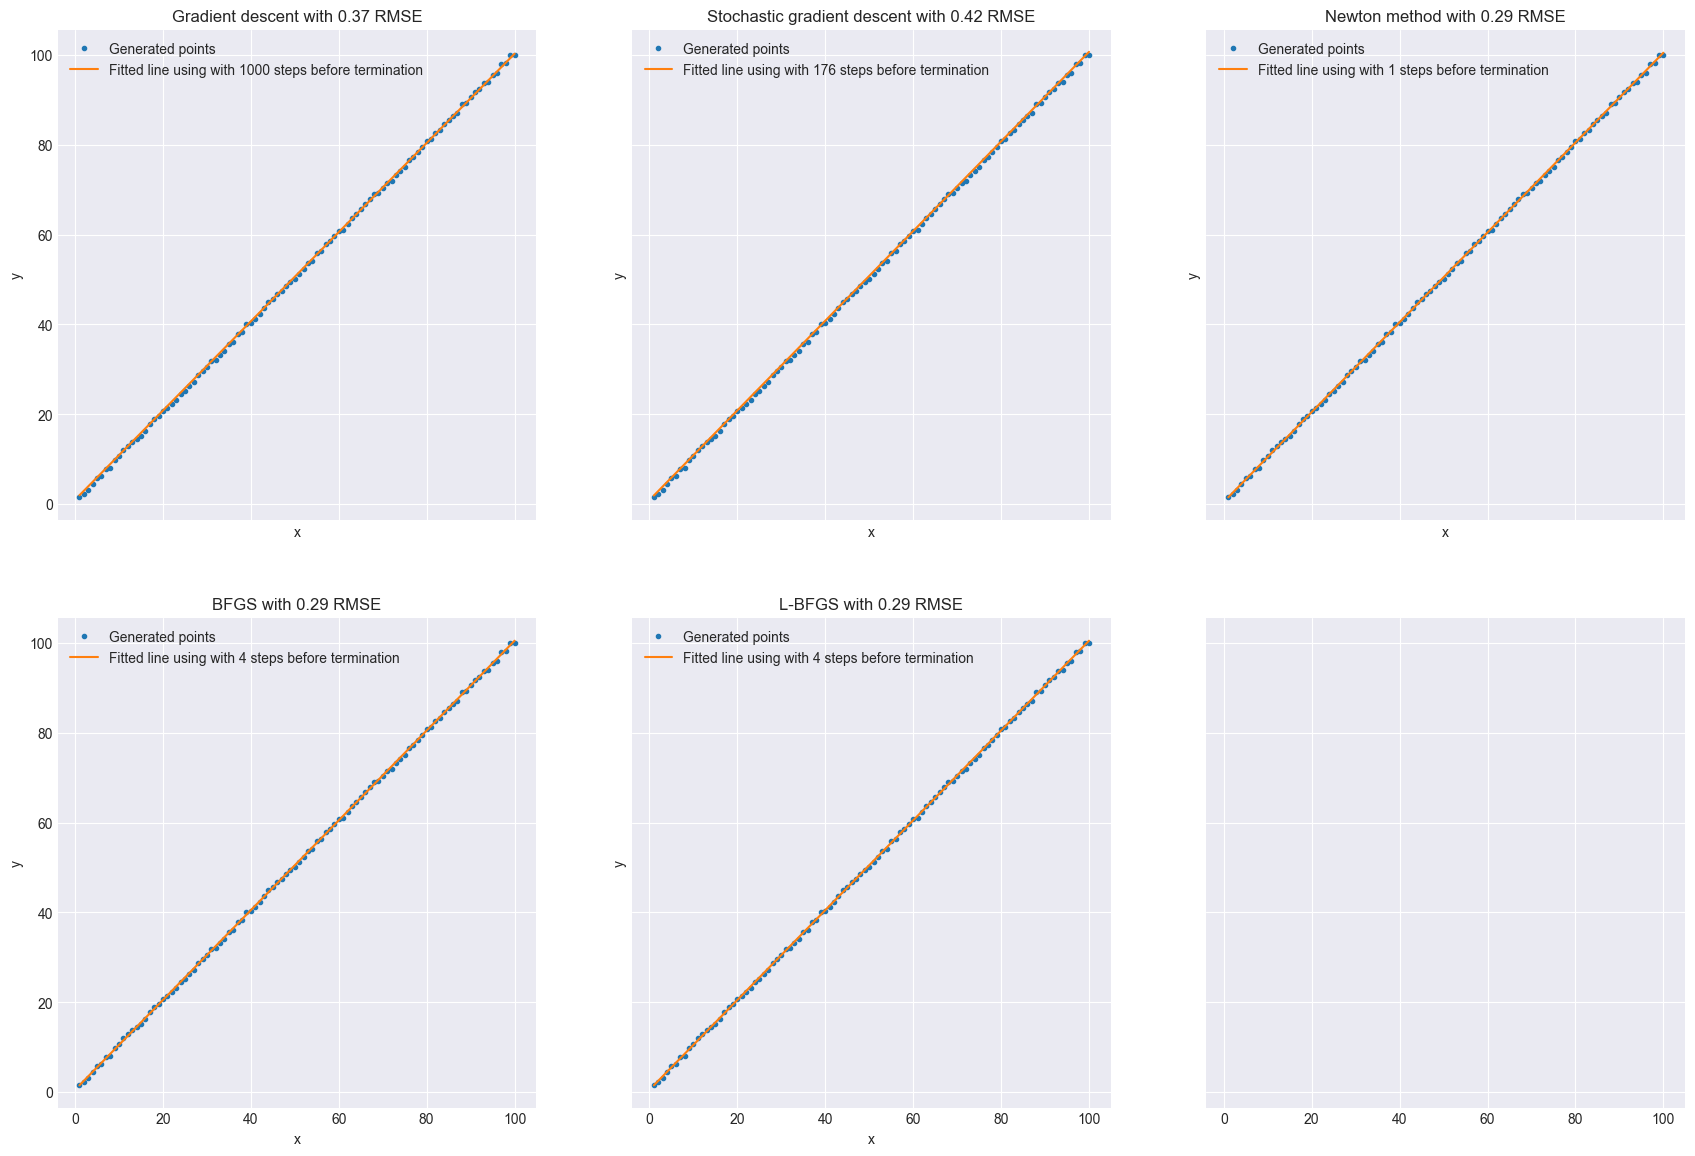

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(21,14), sharex=True, sharey=True)
N = 100
X, y_hat = point_generator(N)
max_steps = 1000
learning_rate = 10e-7
for i,descent in enumerate(methods):
    fail = False
    if descent == 'Gradient descent':
        W, time_steps = gd(X, y_hat, np.array([1,3]), learning_rate, max_steps)
    elif descent == 'Stochastic gradient descent':
        W, time_steps = sgd(X, y_hat, np.array([1,3]), learning_rate*100, max_steps)
    elif descent == 'Newton method':
        W, time_steps = newton(X, y_hat, np.array([1,3]), max_steps)
        # fail = True
    elif descent == 'BFGS':
        W, time_steps = BFGS(X, y_hat, np.array([1,3]), max_steps)
    elif descent == 'L-BFGS':
        W, time_steps = L_BFGS(X, y_hat, np.array([1,3]), 0, max_steps)

    plot_linear_regression(X, y_hat, W, descent, time_steps, RMSE(X@W[-1,:], y_hat), axs[i//3][i%3], fail)

With **N=1 000** we don't observe any new changes. Note that learning rates are smaller for gradient descent.

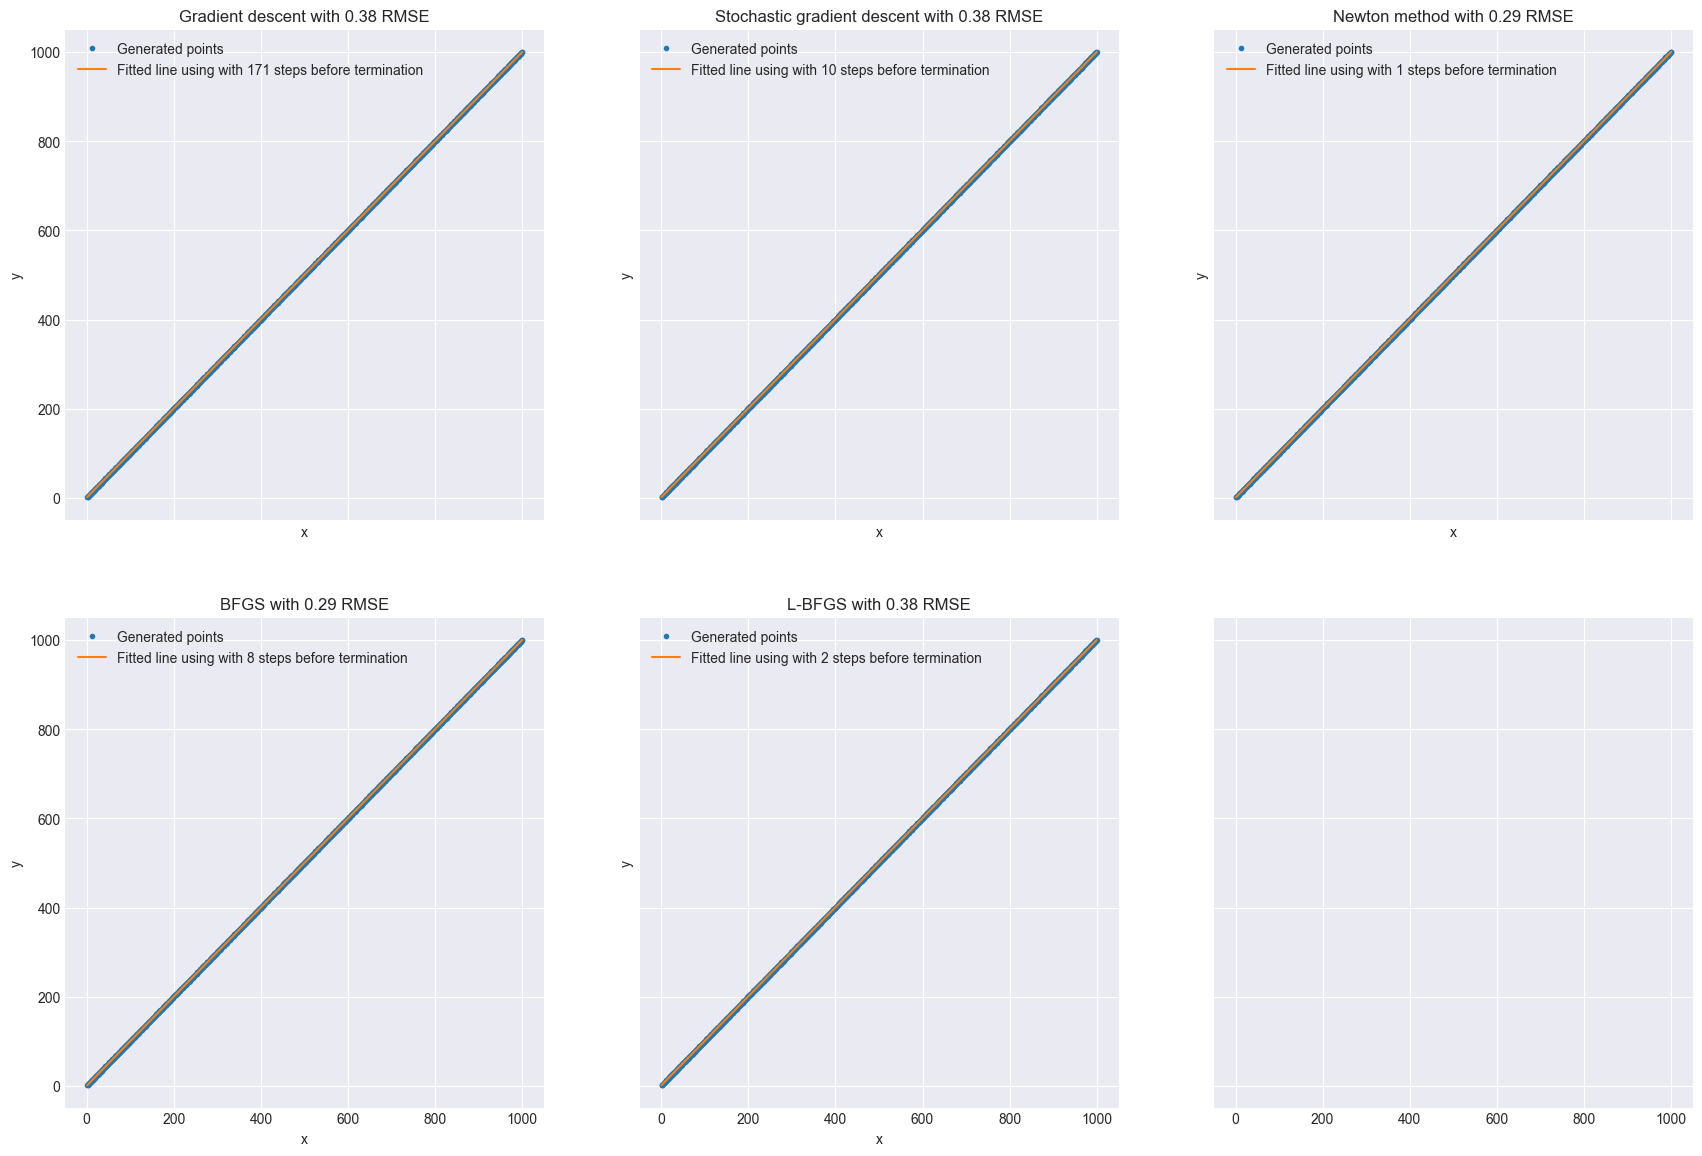

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(21,14), sharex=True, sharey=True)
N = 1000
X, y_hat = point_generator(N)
max_steps = 1000
learning_rate = 10e-11
for i,descent in enumerate(methods):
    fail = False
    if descent == 'Gradient descent':
        W, time_steps = gd(X, y_hat, np.array([1,3]), learning_rate, max_steps)
    elif descent == 'Stochastic gradient descent':
        W, time_steps = sgd(X, y_hat, np.array([1,3]), learning_rate*10000, max_steps)
    elif descent == 'Newton method':
        W, time_steps = newton(X, y_hat, np.array([1,3]), max_steps)
        # fail = True
    elif descent == 'BFGS':
        W, time_steps = BFGS(X, y_hat, np.array([1,3]), max_steps)
    elif descent == 'L-BFGS':
        W, time_steps = L_BFGS(X, y_hat, np.array([1,3]), 0, max_steps)

    plot_linear_regression(X, y_hat, W, descent, time_steps, RMSE(X@W[-1,:], y_hat), axs[i//3][i%3], fail)

With **N=10 000** the Newton method fails, while BFGS and L-BFGS still converge in 5 steps. Gradient descent still gets a good RMSE (with cherry picked learning rate of course).

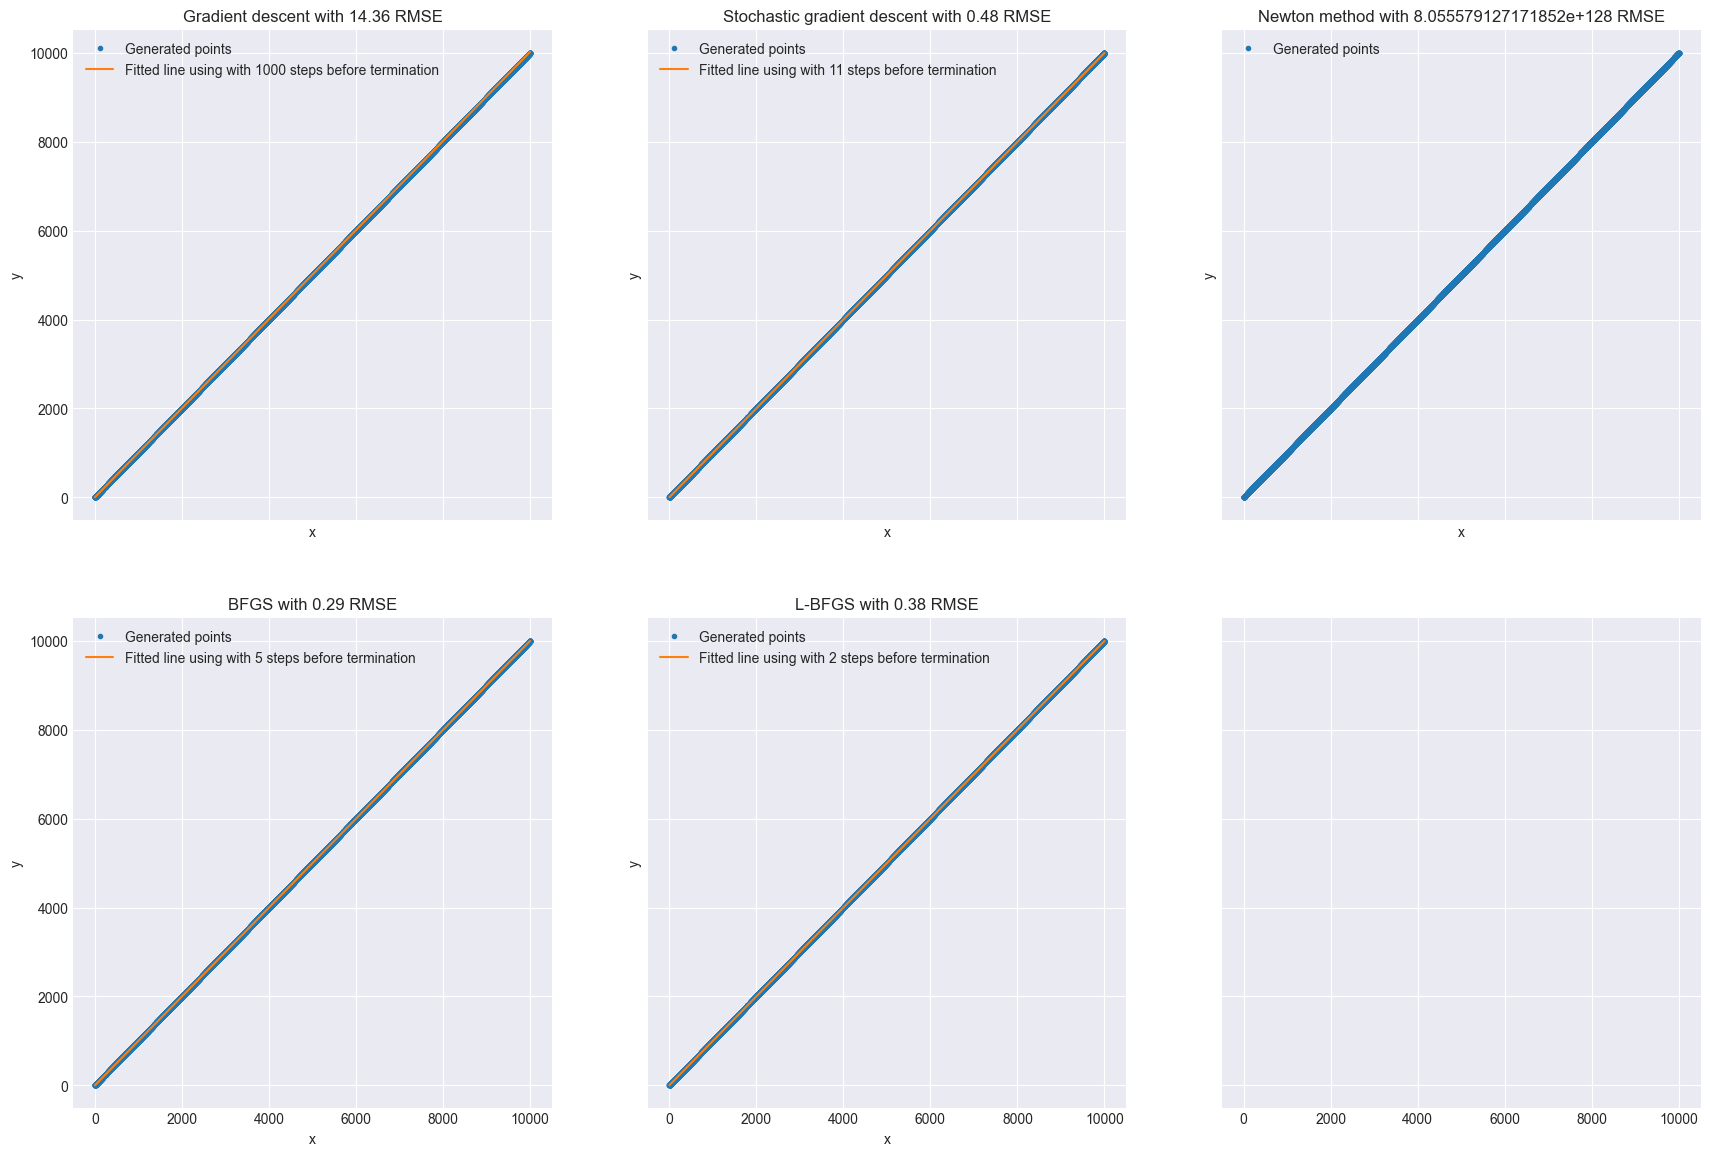

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(21,14), sharex=True, sharey=True)
N = 10000
X, y_hat = point_generator(N)
max_steps = 1000
learning_rate = 10e-15
for i,descent in enumerate(methods):
    fail = False
    if descent == 'Gradient descent':
        W, time_steps = gd(X, y_hat, np.array([1,3]), learning_rate, max_steps)
    elif descent == 'Stochastic gradient descent':
        W, time_steps = sgd(X, y_hat, np.array([1,3]), learning_rate*1000000, max_steps)
    elif descent == 'Newton method':
        W, time_steps = newton(X, y_hat, np.array([1,3]), max_steps)
        fail = True
    elif descent == 'BFGS':
        W, time_steps = BFGS(X, y_hat, np.array([1,3]), max_steps)
    elif descent == 'L-BFGS':
        W, time_steps = L_BFGS(X, y_hat, np.array([1,3]), 0, max_steps)

    plot_linear_regression(X, y_hat, W, descent, time_steps, RMSE(X@W[-1,:], y_hat), axs[i//3][i%3], fail)

For **N=100 000** and **N=1 000 000** we do not observe any changes. Newton methods still fails to converge, meanwhile BFGS and L-BFGS converge in really small number of steps. Gradient descent still manages to get good RMSE with a good learning rate.

C:\Users\Matej\AppData\Local\Temp\ipykernel_4212\421346491.py:2: RuntimeWarning: invalid value encountered in matmul
  return -2*X.T @ (y_hat - X @ w)


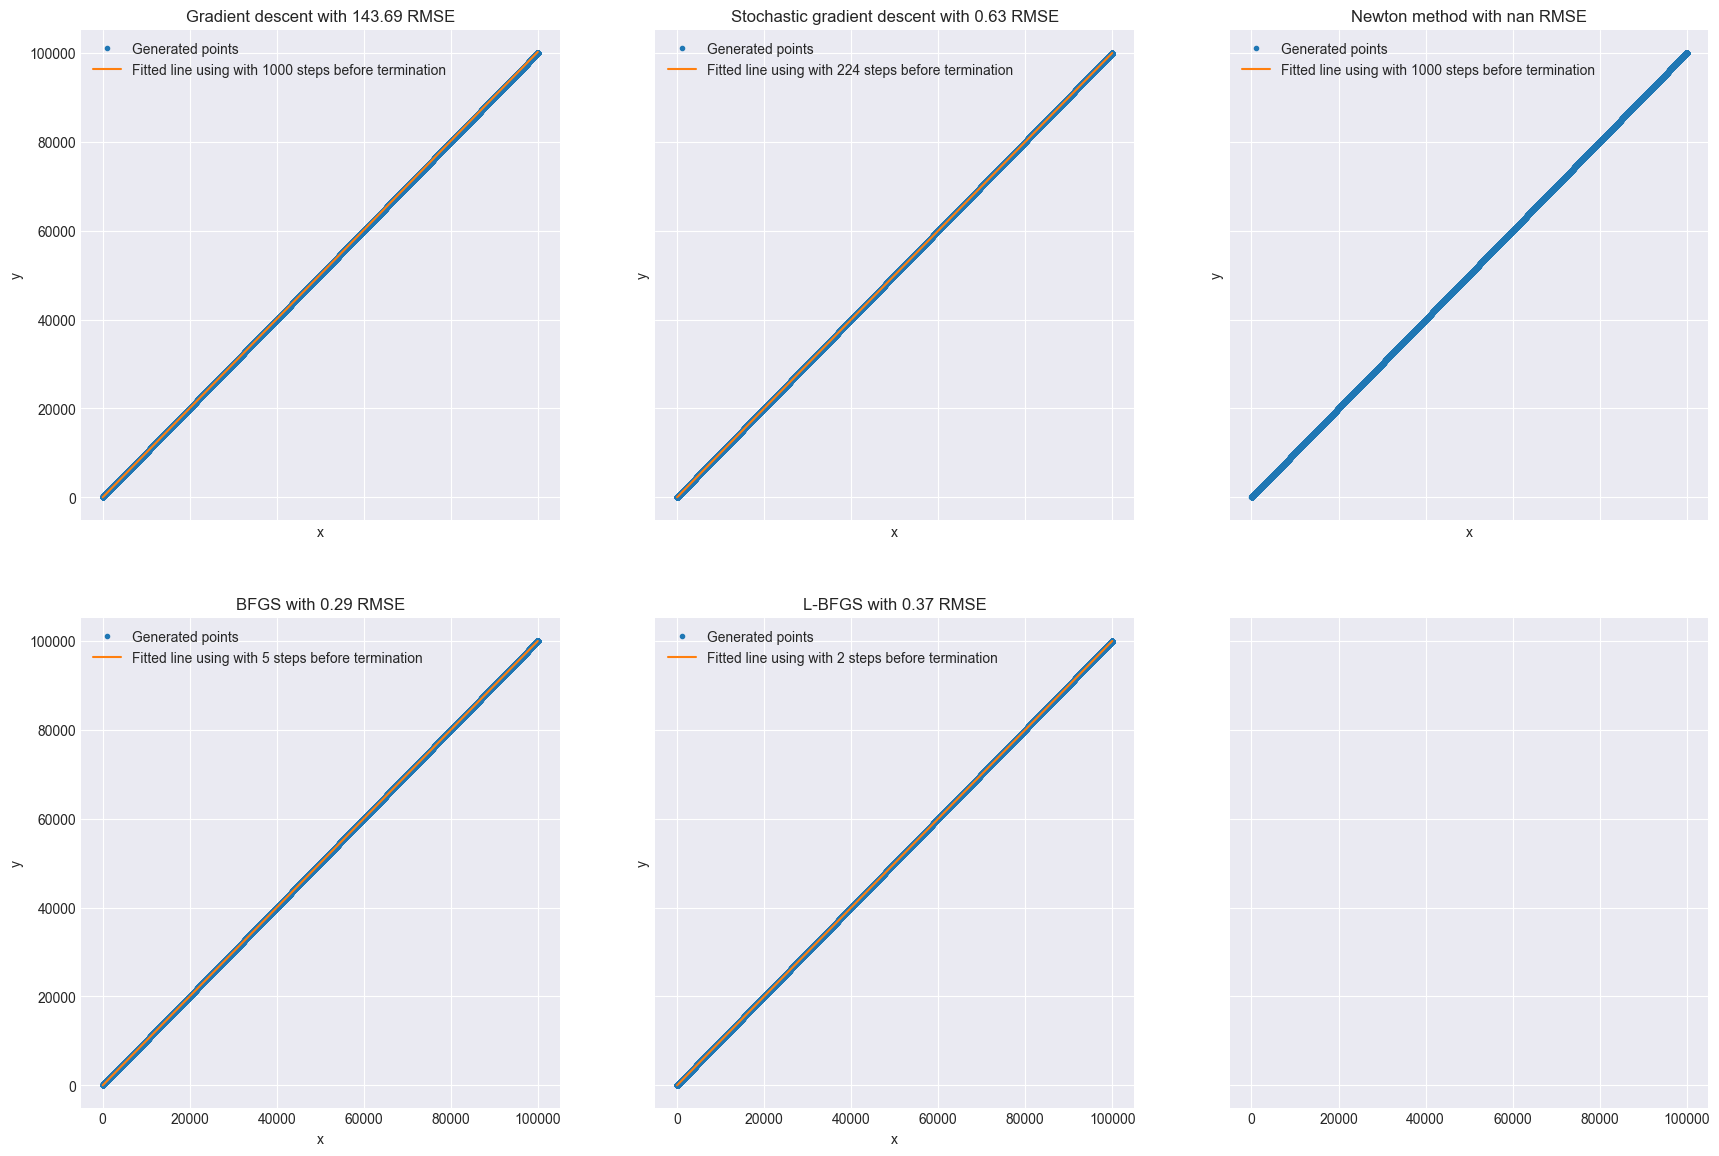

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(21,14), sharex=True, sharey=True)
N = 100000
X, y_hat = point_generator(N)
max_steps = 1000
learning_rate = 10e-18
for i,descent in enumerate(methods):
    if descent == 'Gradient descent':
        W, time_steps = gd(X, y_hat, np.array([1,3]), learning_rate, max_steps)
    elif descent == 'Stochastic gradient descent':
        W, time_steps = sgd(X, y_hat, np.array([1,3]), learning_rate*5000000, max_steps)
    elif descent == 'Newton method':
        W, time_steps = newton(X, y_hat, np.array([1,3]), max_steps)
    elif descent == 'BFGS':
        W, time_steps = BFGS(X, y_hat, np.array([1,3]), max_steps)
    elif descent == 'L-BFGS':
        W, time_steps = L_BFGS(X, y_hat, np.array([1,3]), 0, max_steps)

    plot_linear_regression(X, y_hat, W, descent, time_steps, RMSE(X@W[-1,:], y_hat), axs[i//3][i%3])

C:\Users\Matej\AppData\Local\Temp\ipykernel_4212\421346491.py:2: RuntimeWarning: overflow encountered in matmul
  return -2*X.T @ (y_hat - X @ w)
C:\Users\Matej\AppData\Local\Temp\ipykernel_4212\421346491.py:27: RuntimeWarning: invalid value encountered in matmul
  w = w - np.linalg.inv(hessian(X)) @ grad(X, y_hat, w)
C:\Users\Matej\AppData\Local\Temp\ipykernel_4212\421346491.py:29: RuntimeWarning: invalid value encountered in subtract
  if np.linalg.norm(w - weights[-2]) < 10e-7: return np.array(weights), i


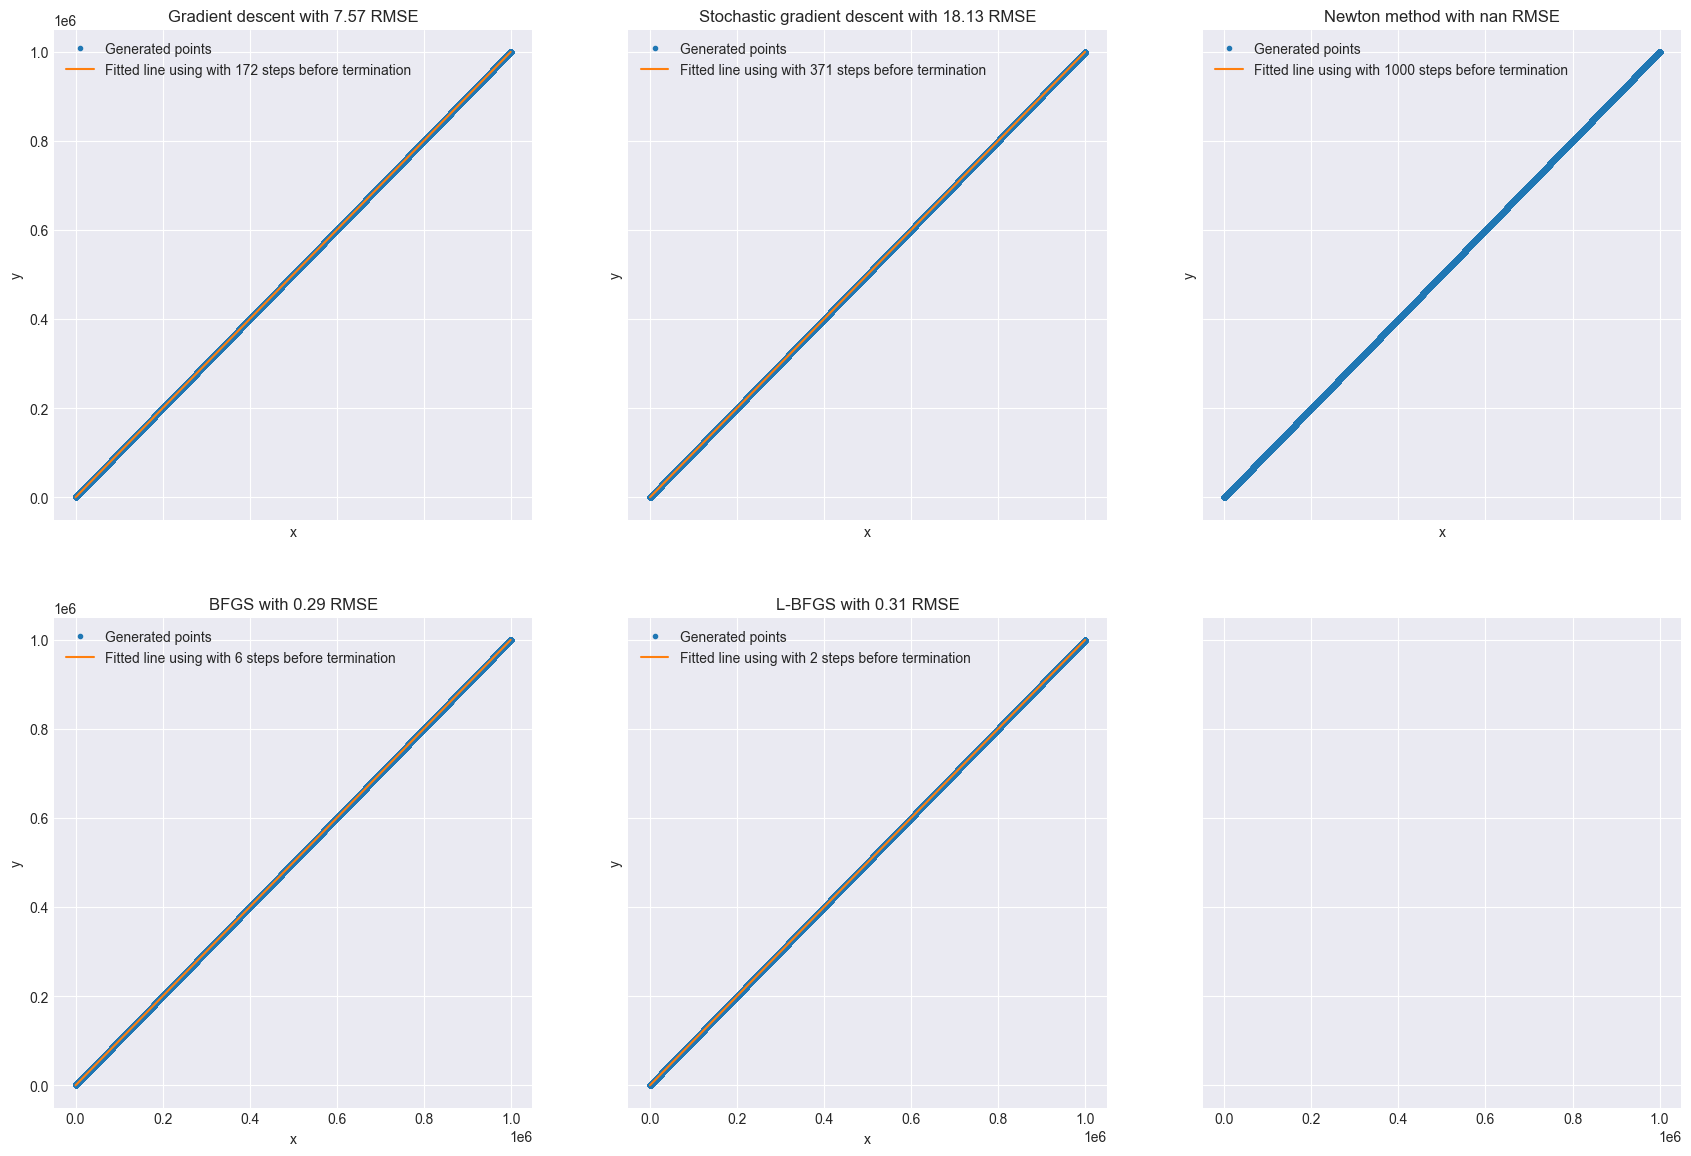

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(21,14), sharex=True, sharey=True)
N = 1000000
X, y_hat = point_generator(N)
max_steps = 1000
learning_rate = 10e-20
for i,descent in enumerate(methods):
    if descent == 'Gradient descent':
        W, time_steps = gd(X, y_hat, np.array([1,3]), learning_rate, max_steps)
    elif descent == 'Stochastic gradient descent':
        W, time_steps = sgd(X, y_hat, np.array([1,3]), learning_rate*1000000, max_steps)
    elif descent == 'Newton method':
        W, time_steps = newton(X, y_hat, np.array([1,3]), max_steps)
    elif descent == 'BFGS':
        W, time_steps = BFGS(X, y_hat, np.array([1,3]), max_steps)
    elif descent == 'L-BFGS':
        W, time_steps = L_BFGS(X, y_hat, np.array([1,3]), 0, max_steps)

    plot_linear_regression(X, y_hat, W, descent, time_steps, RMSE(X@W[-1,:], y_hat), axs[i//3][i%3])